### Finray Simulation

In [1]:
import mujoco
import mujoco_viewer
import numpy as np
import os
from lxml import etree
import lxml.etree as ET
import time
import uuid
import tempfile


##############################################
# Helper functions for XML attribute swapping
##############################################
def swap_par(tree, element_type, element_name, attribute_name, new_value):
    element = tree.find(f'.//{element_type}[@name="{element_name}"]')
    if element is not None:
        element.set(attribute_name, new_value)

##############################################
# Helper function to add a dynamic site to a body
##############################################
def add_dynamic_site(tree, body_name, site_name, pos):
    body_elem = tree.find(f'.//body[@name="{body_name}"]')
    if body_elem is not None:
        new_site = ET.Element("site", name=site_name, size="0.0001", pos=pos, rgba="1 0 0 1")
        body_elem.append(new_site)
    return site_name

#########################################################
# Function to generate a cantilever beam XML segment string
#########################################################
def generate_xml(ID, n):
    xml_output = []
    n_closers = n
    if isinstance(ID, str) and ID.startswith("R"):
        xml_output.append('<body>')
        xml_output.append('<joint type="free"/>')
        n_closers += 1
    xml_output.append(f'<body name="ID{ID}_b_0" pos="0 0 0" euler="0 0 0">')
    xml_output.append(f'<site name="ID{ID}_b_0_sroot" size="0.0001" pos="0 0 0"/>')
    xml_output.append(f'<geom name="ID{ID}_b_0_g" type="box" size="0.0005 0.005 0.01" pos="0 0 0.01" rgba="0.1 0.1 0.1 0.5"/>')
    xml_output.append(f'<site name="ID{ID}_b_0_s" size="0.0001" pos="0 0 0.05"/>')
    for i in range(1, n + 1):
        xml_output.append(f'<body name="ID{ID}_b_{i}" pos="0 0 0" euler="0 0 0">')
        xml_output.append(f'<joint name="ID{ID}_b_{i}_j" type="hinge" axis="0 1 0" pos="0 0 0" stiffness="0" damping="0.00001"/>')
        xml_output.append(f'<geom name="ID{ID}_b_{i}_g" type="box" size="0.0005 0.005 0.01" pos="0 0 0.01" rgba="0.1 0.1 0.1 0.5"/>')
        xml_output.append(f'<site name="ID{ID}_b_{i}_s" size="0.0001" pos="0 0 0.05"/>')
    xml_output.append(f'<site name="ID{ID}_b_{n+1}_s" size="0.0001" pos="0 0 0.05"/>')
    for i in range(n_closers + 1):
        xml_output.append('</body>')
    return '\n'.join(xml_output)

#########################################################
# Function to update geometry and dynamic parameters in XML tree
#########################################################
def reparcer(ID, geom_pars, n, tree, stiffness_factor):
    L, b, t, alpha_k = geom_pars
    l_i = L / n
    l_0 = l_i / 2
    E = 18.5e6
    I = t**3 * b / 12
    k_i = (E * I / l_i) * stiffness_factor
    d_i = k_i * alpha_k
    for i in range(0, n+1):
        if i == 0:
            swap_par(tree, 'geom', f'ID{ID}_b_0_g', 'size', f"{t/2} {b/2} {l_0/2}")
            swap_par(tree, 'geom', f'ID{ID}_b_0_g', 'pos', f"0 0 {l_0/2}")
            swap_par(tree, 'site', f'ID{ID}_b_0_s', 'pos', f"0 0 {l_0/2}")
        elif i == n:
            swap_par(tree, 'body', f'ID{ID}_b_{i}', 'pos', f"0 0 {l_i}")
            swap_par(tree, 'geom', f'ID{ID}_b_{i}_g', 'size', f"{t/2} {b/2} {l_0/2}")
            swap_par(tree, 'geom', f'ID{ID}_b_{i}_g', 'pos', f"0 0 {l_0/2}")
            swap_par(tree, 'site', f'ID{ID}_b_{i}_s', 'pos', f"0 0 {l_0/2}")
            swap_par(tree, 'joint', f'ID{ID}_b_{i}_j', 'stiffness', f"{k_i}")
            swap_par(tree, 'joint', f'ID{ID}_b_{i}_j', 'damping', f"{d_i}")
        else:
            pos = l_0 if i == 1 else l_i
            swap_par(tree, 'body', f'ID{ID}_b_{i}', 'pos', f"0 0 {pos}")
            swap_par(tree, 'geom', f'ID{ID}_b_{i}_g', 'size', f"{t/2} {b/2} {l_i/2}")
            swap_par(tree, 'geom', f'ID{ID}_b_{i}_g', 'pos', f"0 0 {l_i/2}")
            swap_par(tree, 'site', f'ID{ID}_b_{i}_s', 'pos', f"0 0 {l_i/2}")
            swap_par(tree, 'joint', f'ID{ID}_b_{i}_j', 'stiffness', f"{k_i}")
            swap_par(tree, 'joint', f'ID{ID}_b_{i}_j', 'damping', f"{d_i}")
            swap_par(tree, 'site', f'ID{ID}_b_{n+1}_s', 'pos', f"0 0 {l_0}")

def site_searcher(L, L_site, n):
    li = L / n
    l0 = li / 2
    segments = [l0] + [li] * (n - 1) + [l0]
    cumulative = 0.0
    for idx, seg_length in enumerate(segments):
        if cumulative + seg_length >= L_site:
            local_offset = L_site - cumulative
            return idx, local_offset
        cumulative += seg_length
    return len(segments) - 1, segments[-1]

#########################################################
# Combined function: generate a parameterized Finray model and run simulation
#########################################################
def run_finray_simulation(
    rib_angles_deg,
    thickness_ribs,
    n_springs_front,
    n_springs_back,
    n_springs_rib,
    thickness_front,
    thickness_back,
    beam_width,
    L0,
    X1,
    xf,
    zf,
    moving_cylinder_x,
    moving_cylinder_z,
    moving_cylinder_radius,
    moving_cylinder_displacement,
    vis,
    stiffness_factor 
):
    alpha_k = 5e-3
    phi_a = np.arctan((L0 - zf) / xf)
    phi_b = -np.arctan(zf / (X1 + xf))
    beta = np.arctan(L0 / X1)
    L1 = np.sqrt(L0**2 + X1**2)

    ribs_geom = {}
    valid_rib_indices = []
    for idx, angle_deg in enumerate(rib_angles_deg):
        phi_r = np.deg2rad(angle_deg)
        if phi_r < phi_b or phi_r > phi_a:
            continue
        L_A = zf + xf * np.tan(phi_r)
        L_B = (X1 * np.tan(phi_r) + L_A) / (np.sin(beta) + np.cos(beta) * np.tan(phi_r))
        P_A_z = L_A
        P_B_x = X1 - L_B * np.sin(0.5 * np.pi - beta)
        P_B_z = L_B * np.cos(0.5 * np.pi - beta)
        L_rib = np.sqrt((0 - P_B_x)**2 + (P_A_z - P_B_z)**2)
        alpha_rib = np.arcsin((P_B_z - P_A_z) / L_rib)
        ribs_geom[idx] = {'L_A': L_A, 'L_B': L_B, 'P_A_z': P_A_z, 'L_rib': L_rib, 'alpha_rib': alpha_rib}
        valid_rib_indices.append(idx)
    valid_rib_indices = [idx for idx in valid_rib_indices if ribs_geom[idx]['P_A_z'] >= 0]

    xml_front = generate_xml("F", n_springs_front)
    xml_back = generate_xml("B", n_springs_back)
    xml_ribs = {idx: generate_xml(f"R{idx}", n_springs_rib) for idx in valid_rib_indices}

    base_xml_path = "Finray_model.xml"
    mod_xml_path = "Finray_model_mod.xml"
    
    mod_xml_path = os.path.join(tempfile.gettempdir(), f"finray_{uuid.uuid4().hex}.xml")
    
    hand_tree = ET.parse(base_xml_path)
    hand_root = hand_tree.getroot()
    eq = hand_root.find("equality")
    if eq is not None:
        eq.clear()

    worldbody = hand_root.find("worldbody")
    worldbody.append(ET.fromstring(xml_front))
    worldbody.append(ET.fromstring(xml_back))
    for xml in xml_ribs.values():
        worldbody.append(ET.fromstring(xml))
    focal_site = ET.Element("site", name="focal_site", pos=f"{-xf} 0 {zf}", size="0.001", rgba="0 1 0 0.1", type="sphere")
    worldbody.append(focal_site)

    for idx in valid_rib_indices:
        start = np.array([-xf, 0, zf])
        end = np.array([0, 0, ribs_geom[idx]['P_A_z']])
        vec = end - start
        length = np.linalg.norm(vec)
        midpoint = start + vec/2
        angle = np.arccos(vec[2] / length)
        q0, q2 = np.cos(angle/2), np.sin(angle/2)
        geom = ET.Element("geom", name=f"focal_line_{idx}", type="cylinder",
                          pos=f"{midpoint[0]} {midpoint[1]} {midpoint[2]}",
                          quat=f"{q0} 0 {q2} 0",
                          size=f"0.0005 {length/2}", rgba="0 1 0 0.1", contype="0", conaffinity="0")
        worldbody.append(geom)

    hand_tree.write(mod_xml_path, pretty_print=True)
    tree = etree.parse(mod_xml_path)
    root = tree.getroot()
    worldbody = root.find("worldbody")

    # Update beam parameters
    reparcer("F", [L0, beam_width, thickness_front, alpha_k], n_springs_front, tree, stiffness_factor)
    reparcer("B", [L1, beam_width, thickness_back, alpha_k], n_springs_back, tree, stiffness_factor)
    for idx in valid_rib_indices:
        rib_t = thickness_ribs[idx] if thickness_ribs and idx < len(thickness_ribs) else thickness_rib
        reparcer(f"R{idx}", [ribs_geom[idx]['L_rib'], beam_width, rib_t, alpha_k], n_springs_rib, tree, stiffness_factor)

    # Position back beam
    swap_par(tree, 'body', 'IDB_b_0', 'euler', f"0 {-np.rad2deg(0.5*np.pi - beta)} 0")
    swap_par(tree, 'body', 'IDB_b_0', 'pos', f"{X1} 0 0")
    # Position ribs
    for idx in valid_rib_indices:
        swap_par(tree, 'body', f'IDR{idx}_b_0', 'euler', f"0 {90 - np.rad2deg(ribs_geom[idx]['alpha_rib'])} 0")
        swap_par(tree, 'body', f'IDR{idx}_b_0', 'pos', f"0 0 {ribs_geom[idx]['P_A_z']}")

    # Connections
    conn_sites = {}
    for idx in valid_rib_indices:
        i_f, l_f = site_searcher(L0, ribs_geom[idx]['L_A'], n_springs_front)
        i_b, l_b = site_searcher(L1, ribs_geom[idx]['L_B'], n_springs_back)
        sf, sb = f"IDF_b_{i_f}_conn_{idx}", f"IDB_b_{i_b}_conn_{idx}"
        add_dynamic_site(tree, f"IDF_b_{i_f}", sf, f"0 0 {l_f}")
        add_dynamic_site(tree, f"IDB_b_{i_b}", sb, f"0 0 {l_b}")
        conn_sites[idx] = (sf, sb)

    eq = tree.find("equality")
    if eq is None:
        eq = ET.SubElement(root, "equality")
    eq.append(ET.Element("weld", name="connect_fin", site1=f"IDF_b_{n_springs_front+1}_s", site2=f"IDB_b_{n_springs_back+1}_s"))
    for idx in valid_rib_indices:
        sf, sb = conn_sites[idx]
        eq.append(ET.Element("weld", name=f"connect_rib_A{idx}", site1=sf, site2=f"IDR{idx}_b_0_sroot"))
        eq.append(ET.Element("weld", name=f"connect_rib_B{idx}", site1=sb, site2=f"IDR{idx}_b_{n_springs_rib+1}_s"))

    # Moving cylinder body, joint, geom and force site
    moving_body = ET.Element("body", name="moving_cylinder", pos=f"{-moving_cylinder_x} 0 {moving_cylinder_z}", euler="90 0 0")
    moving_joint = ET.Element("joint", name="slider_joint", type="slide", axis="1 0 0", limited="true", range="-0.5 0.5", damping="1")
    
    moving_body.insert(0, moving_joint)
    moving_geom = ET.Element("geom", name="moving_cylinder_geom", type="cylinder",
                             pos="0 0 0", size=f"{moving_cylinder_radius} 0.1",
                             rgba="0.8 0.2 0.2 0.4", euler="0 0 90",
                             condim="4", contype="1", conaffinity="15",
                             friction="0.9 0.2 0.2", solref="0.001 2")
    moving_body.append(moving_geom)
    # Add site for force-based actuator
    moving_site = ET.Element("site", name="cylinder_site", pos="0 0 0", size="0.001", rgba="0 0 1 1")
    moving_body.append(moving_site)
    worldbody.append(moving_body)

    # Define general (force) actuator
    
    #actuator_elem = root.find("actuator") or ET.SubElement(root, "actuator")
    #actuator_elem.clear()
    #general_elem = ET.Element("general", name="applied_force", site="cylinder_site", gear="1 0 0")
    #actuator_elem.append(general_elem)
    
    actuator_elem = root.find("actuator")
    if actuator_elem is None:
        actuator_elem = ET.Element("actuator")
        root.append(actuator_elem)
    position_elem = ET.Element("position", name="cylinder_actuator", joint="slider_joint", kp="20000", dampratio="1", ctrlrange="-0.5 0.5")
    actuator_elem.append(position_elem)

    tree.write(mod_xml_path, pretty_print=True, xml_declaration=True, encoding='UTF-8')
    
    #########################################################
    # Run simulation
    #########################################################
    model = mujoco.MjModel.from_xml_path(mod_xml_path)
    data = mujoco.MjData(model)
    viewer = mujoco_viewer.MujocoViewer(model, data, title=mod_xml_path, width=1200, height=600)
    
    cam_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_CAMERA, "side view")
    viewer.cam.type       = mujoco.mjtCamera.mjCAMERA_FIXED   # тип — fixed camera :contentReference[oaicite:3]{index=3}
    viewer.cam.fixedcamid = cam_id 

    sim_time = 8
    timestep = 0.001
    STEP_NUM = int(sim_time / timestep)
    
    n_sites_front = n_springs_front + 2 + len(valid_rib_indices)
    pos_front_init = np.zeros((n_sites_front, 2))
    pos_front_deform = np.zeros((n_sites_front, 2))
    
    n_sites_back = n_springs_back + 2 + len(valid_rib_indices)
    pos_back_init = np.zeros((n_sites_back, 2))
    pos_back_deform = np.zeros((n_sites_back, 2))
        
    contact_points_X = []
    contact_points_Z = []
    
    contact_forces_X = []
    contact_forces_Z = []

    act_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, 'cylinder_actuator')

    for i in range(STEP_NUM):
        if not viewer.is_alive:
            break
        data.ctrl[act_id] = moving_cylinder_displacement
        if i == 1:
            for j in range(n_sites_front):
                p = data.site_xpos[j + 1]
                pos_front_init[j] = [p[0], p[2]]
            # Logging back sites
            base_idx = 1 + n_sites_front
            for j in range(n_sites_back):
                p = data.site_xpos[base_idx + j]
                pos_back_init[j] = [p[0], p[2]]
        if i == STEP_NUM - 1:
            for j in range(n_sites_front):
                p = data.site_xpos[j + 1]
                pos_front_deform[j] = [p[0], p[2]]
            # Logging back sites
            base_idx = 1 + n_sites_front
            for j in range(n_sites_back):
                p = data.site_xpos[base_idx + j]
                pos_back_deform[j] = [p[0], p[2]]
        mujoco.mj_step(model, data)
        
        # Сбор данных только в последнем кадре
        if i == STEP_NUM - 1:
            for contact_idx in range(data.ncon):
                contact = data.contact[contact_idx]
                
                # Extract contact points
                pos = np.array(contact.pos)
                contact_points_X.append(pos[0])
                contact_points_Z.append(pos[2])
                
                # Extract contact forces
                ft = np.zeros(6)
                mujoco.mj_contactForce(model, data, contact_idx, ft)
                contact_xmat = np.array(contact.frame).reshape(3,3).T
                world_f = contact_xmat @ ft[:3]
                contact_forces_X.append(world_f[0])
                contact_forces_Z.append(world_f[2])
      
        if vis:
            viewer.render()

    viewer.close()
    os.remove(mod_xml_path)
    
    dx = np.diff(contact_points_X)
    dz = np.diff(contact_points_Z)
    segment_lengths = np.sqrt(dx**2 + dz**2)
    con_len = np.sum(segment_lengths) # total curve length    
    con_S = con_len * beam_width # contact area
    
    front_joint_ids = [mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, f"IDF_b_{i}_j")
                       for i in range(1, n_springs_front+1)]
    back_joint_ids  = [mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, f"IDB_b_{i}_j")
                       for i in range(1, n_springs_back+1)]

    # Извлекаем текущие углы (qpos) и жесткости (из модели)
    E_front = 0.0
    for jid in front_joint_ids:
        theta = data.qpos[jid]                  # угол сочленения
        k     = model.jnt_stiffness[jid]        # жесткость
        E_front += 0.5 * k * theta**2
    
    E_back = 0.0
    for jid in back_joint_ids:
        theta = data.qpos[jid]
        k     = model.jnt_stiffness[jid]
        E_back += 0.5 * k * theta**2

    # и возвращаем их вместе с остальными данными
    return pos_front_init, pos_front_deform, pos_back_init, pos_back_deform, contact_forces_X, contact_forces_Z, \
           contact_points_X, contact_points_Z, con_S, E_front, E_back, valid_rib_indices

### Identification

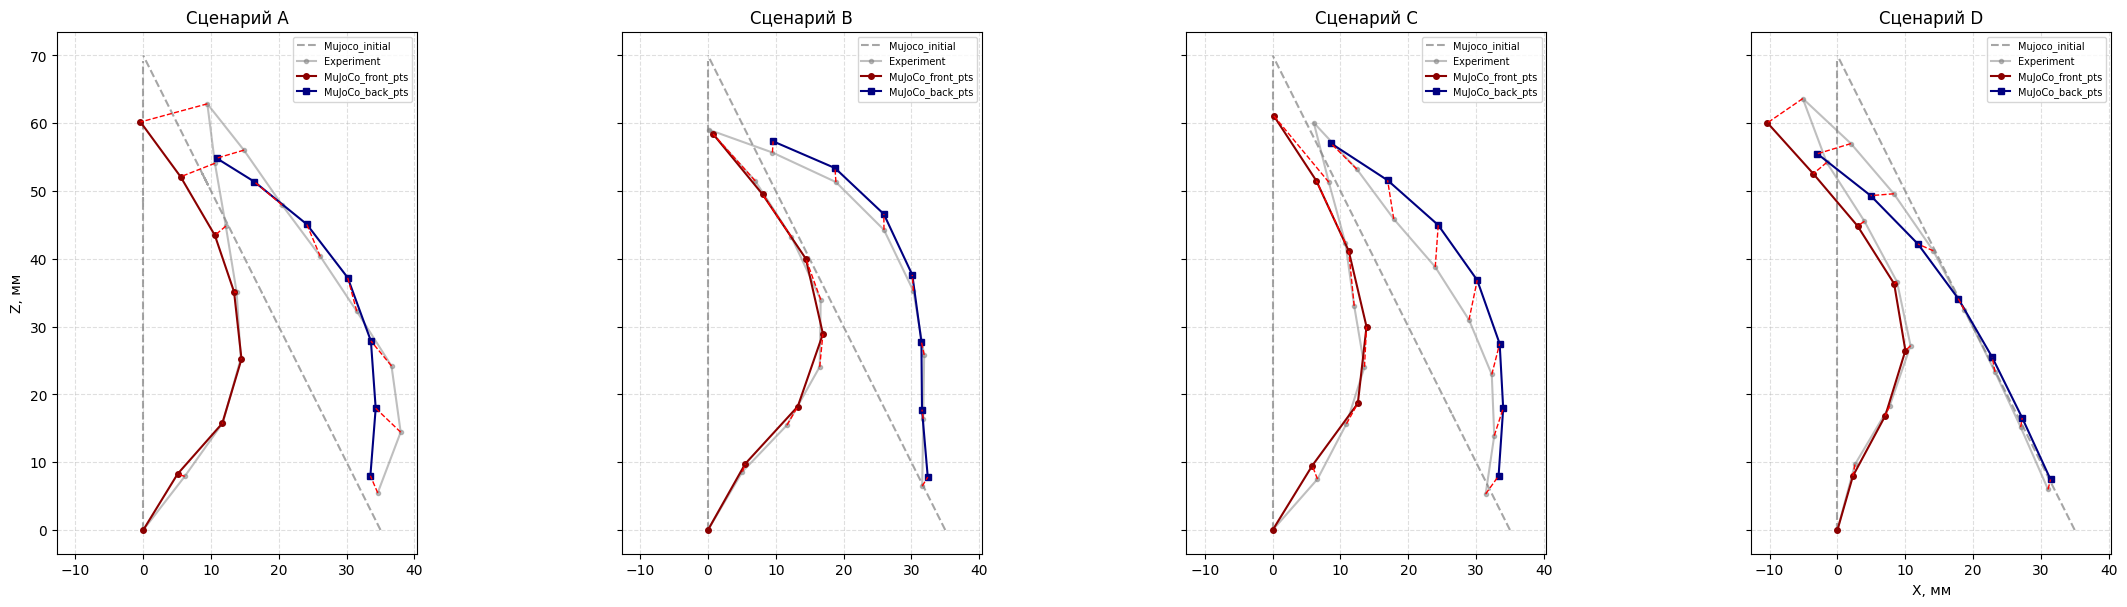

Сценарий A: длина связей = 52.008 мм, погрешность = 38.76%
Сценарий B: длина связей = 45.827 мм, погрешность = 33.04%
Сценарий C: длина связей = 78.149 мм, погрешность = 60.87%
Сценарий D: длина связей = 33.031 мм, погрешность = 23.87%


<Figure size 640x480 with 0 Axes>

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Параметры модели
n_springs_front = 20
n_springs_back  = 20
n_springs_rib   = 15
L0               = 70e-3
X1               = 35e-3
beam_width       = 35e-3
moving_radius    = 20e-3
th_front         = 2e-3
th_back          = 4e-3
stiffness_factor = 1.0

# Функции
def load_and_rotate_experiment(csv_file):
    df = pd.read_csv(csv_file)
    pos1 = df.query("position=='pos_1'").sort_values('index').head(15)[['x_mm','y_mm']]
    pos2 = df.query("position=='pos_2'").sort_values('index').head(15)[['x_mm','y_mm']]
    p0, p7 = pos1.values[0], pos1.values[7]
    angle = np.arctan2(*(p7 - p0)[::-1])
    offset = np.pi/2 - angle
    R = np.array([[np.cos(offset), -np.sin(offset)],
                  [np.sin(offset),  np.cos(offset)]])
    def rotate(pts):
        arr = pts.values - p0
        return pd.DataFrame(arr.dot(R.T) + p0, columns=['x_mm','y_mm'])
    return rotate(pos1), rotate(pos2)

def run_finray(params):
    return run_finray_simulation(**params)

def sample_points_along_curve(x, y, step=10):
    x = np.asarray(x)
    y = np.asarray(y)
    ds = np.sqrt(np.diff(x)**2 + np.diff(y)**2)
    dist = np.concatenate(([0], np.cumsum(ds)))
    total_length = dist[-1]
    n_points = int(np.floor(total_length / step)) + 1
    even_dist = np.linspace(0, total_length, n_points)
    fx = interp1d(dist, x)
    fy = interp1d(dist, y)
    return fx(even_dist), fy(even_dist)

def to_mm(a):
    return a * 1000

# Сценарии
scenarios = {
    'A': {'csv':'A.csv', 'sim':{'rib_angles_deg':[15,0,-15],'thickness_ribs':[3e-3]*3,
        'n_springs_front':n_springs_front,'n_springs_back':n_springs_back,'n_springs_rib':n_springs_rib,
        'thickness_front':th_front,'thickness_back':th_back,'beam_width':beam_width,
        'L0':L0,'X1':X1,'xf':50e-3,'zf':35e-3,
        'moving_cylinder_x':moving_radius + th_front/2,'moving_cylinder_z':26e-3,
        'moving_cylinder_radius':moving_radius,'moving_cylinder_displacement':16e-3,
        'vis':False,'stiffness_factor':stiffness_factor}},
    'B': {'csv':'B.csv', 'sim':{'rib_angles_deg':[],'thickness_ribs':[],
        'n_springs_front':n_springs_front,'n_springs_back':n_springs_back,'n_springs_rib':n_springs_rib,
        'thickness_front':th_front,'thickness_back':th_back,'beam_width':beam_width,
        'L0':L0,'X1':X1,'xf':50e-3,'zf':30e-3,
        'moving_cylinder_x':moving_radius + th_front/2,'moving_cylinder_z':30e-3,
        'moving_cylinder_radius':moving_radius,'moving_cylinder_displacement':18e-3,
        'vis':False,'stiffness_factor':stiffness_factor}},
    'C': {'csv':'C.csv', 'sim':{'rib_angles_deg':[0.5,0,-0.5],'thickness_ribs':[3e-3]*3,
        'n_springs_front':n_springs_front,'n_springs_back':n_springs_back,'n_springs_rib':n_springs_rib,
        'thickness_front':th_front,'thickness_back':th_back,'beam_width':beam_width,
        'L0':L0,'X1':X1,'xf':2000e-3,'zf':35e-3,
        'moving_cylinder_x':moving_radius + th_front/2,'moving_cylinder_z':26e-3,
        'moving_cylinder_radius':moving_radius,'moving_cylinder_displacement':15e-3,
        'vis':False,'stiffness_factor':stiffness_factor}},
    'D': {'csv':'D.csv', 'sim':{'rib_angles_deg':[59.04],'thickness_ribs':[3e-3],
        'n_springs_front':n_springs_front,'n_springs_back':n_springs_back,'n_springs_rib':n_springs_rib,
        'thickness_front':th_front,'thickness_back':th_back,'beam_width':beam_width,
        'L0':L0,'X1':X1,'xf':30e-3,'zf':-50e-3,
        'moving_cylinder_x':moving_radius + th_front/2,'moving_cylinder_z':28e-3,
        'moving_cylinder_radius':moving_radius,'moving_cylinder_displacement':11e-3,
        'vis':False,'stiffness_factor':stiffness_factor}}
}

scenario_names = ['A','B','C','D']
results = {}

# Собираем четыре отдельных оси, но в одну строку, с минимальным промежутком
fig, axes = plt.subplots(1, 4, figsize=(24, 6), sharex=True, sharey=True)
fig.subplots_adjust(left=0.05, right=0.98, top=0.95, bottom=0.08, wspace=0.05)

for ax, name in zip(axes, scenario_names):
    cfg = scenarios[name]
    # Эксперимент
    e1, e2 = load_and_rotate_experiment(cfg['csv'])
    x_exp_def = e2['x_mm'].values
    y_exp_def = e2['y_mm'].values
    # Модель
    pfi, pfd, pbi, pbd = run_finray(cfg['sim'])[:4]
    xi = to_mm(pfi[:,0]); zi = to_mm(pfi[:,1])
    xd = to_mm(pfd[:,0]); zd = to_mm(pfd[:,1])
    xb = np.roll(to_mm(pbi[:,0]), -1); zb = np.roll(to_mm(pbi[:,1]), -1)
    xbd = np.roll(to_mm(pbd[:,0]), -1); zbd = np.roll(to_mm(pbd[:,1]), -1)
    # MuJoCo initial
    ax.plot(xi, zi, '--', linewidth=1.5, color='grey', alpha=0.7, label='Mujoco_initial')
    ax.plot(xb, zb, '--', linewidth=1.5, color='grey', alpha=0.7)
    # Точки после деформации
    xd_pts_full, zd_pts_full = sample_points_along_curve(xd, zd, step=10)
    # Урезаем ровно 8 фронт-точек
    xd_pts = xd_pts_full[:8]
    zd_pts = zd_pts_full[:8]
    ds_back = np.sqrt(np.diff(xb)**2 + np.diff(zb)**2)
    dist_back = np.concatenate(([0], np.cumsum(ds_back)))
    fx_back_def = interp1d(dist_back, xbd)
    fy_back_def = interp1d(dist_back, zbd)
    offsets = 8.262 + np.arange(7) * 10
    xbd_pts = fx_back_def(offsets)
    zbd_pts = fy_back_def(offsets)
    # Эксперимент разделяем
    x_exp_first8 = x_exp_def[:8]
    y_exp_first8 = y_exp_def[:8]
    x_exp_last7  = x_exp_def[-7:][::-1]
    y_exp_last7  = y_exp_def[-7:][::-1]
    # Рисуем
    ax.plot(x_exp_def, y_exp_def, '.-', markersize=6, color='grey', alpha=0.5, label='Experiment')
    ax.plot(xd_pts, zd_pts, 'o-', markersize=4, color='darkred', label='MuJoCo_front_pts')
    ax.plot(xbd_pts, zbd_pts, 's-', markersize=4, color='navy', label='MuJoCo_back_pts')
    # Линии связей
    for i in range(len(xd_pts)):
        ax.plot([x_exp_first8[i], xd_pts[i]],
                [y_exp_first8[i], zd_pts[i]],
                'r--', linewidth=1)
    for i in range(len(xbd_pts)):
        ax.plot([x_exp_last7[i], xbd_pts[i]],
                [y_exp_last7[i], zbd_pts[i]],
                'r--', linewidth=1)
    # Метрики
    front_d = [np.hypot(xd_pts[i]-x_exp_first8[i], zd_pts[i]-y_exp_first8[i])
               for i in range(len(xd_pts))]
    back_d  = [np.hypot(xbd_pts[i]-x_exp_last7[i], zbd_pts[i]-y_exp_last7[i])
               for i in range(len(xbd_pts))]
    total_link = np.sum(front_d) + np.sum(back_d)
    exp_len = np.sum(np.hypot(np.diff(x_exp_def), np.diff(y_exp_def)))
    rel_err = total_link / exp_len * 100
    results[name] = {'total': total_link, 'err': rel_err}
    ax.set_title(f'Сценарий {name}')
    ax.set_aspect('equal')
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.legend(fontsize=7, loc='upper right')

axes[-1].set_xlabel('X, мм')
axes[0].set_ylabel('Z, мм')
plt.show()

for name in scenario_names:
    r = results[name]
    print(f"Сценарий {name}: длина связей = {r['total']:.3f} мм, погрешность = {r['err']:.2f}%")
    
plt.savefig("identification.png")